<a href="https://colab.research.google.com/github/mohak0900/Summer-Analytics-2023/blob/main/SA_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 SA

Hey Everyone!!
We hope that you are excited to apply your newly acquired knowledge and test it on this notebook.
In this assignment, we will be walking through creating an email classifier based the content the mail has.

## About the data

The data "email.csv" has a few rows and about 3K columns including <b>Email_no.</b> and <b>spam</b>. <br>
Email_no. is like a unique id for an email and spam denotes whether the given mail is a spam or not (0 = not spam, 1 = spam)<br>
Rest of the columns are words in english with the values being equal to the frequency of that word in the email.
<br>Our goal is to predict whether the given mail is spam or not

## Importing useful libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.svm import SVC
import seaborn as sns

## Loading the data
### If you are using Datalore, you may use the csv file directly. Otherwise you may download it from <a href = "https://drive.google.com/file/d/1OxJ6SSuPypg-AfLbMRl0O9So9aDDNzbC/view?usp=sharing">this link</a>

In [ ]:
df = pd.read_csv('/content/emails (1).csv')

## Describe the data and generate some basic insights unsing methods like .info

In [ ]:
df.shape

(5172, 3002)

In [ ]:
df.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


Number of non-spam emails: 3672
Number of spam emails: 1500


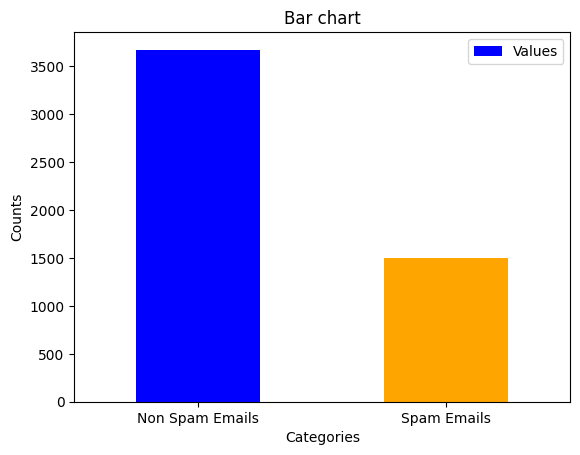

In [ ]:
# Separate spam and non-spam emails
spam_emails = df[df["Prediction"] == 1]
non_spam_emails = df[df["Prediction"] == 0]
spam_count = len(spam_emails)
non_spam_count = len(non_spam_emails)

print("Number of non-spam emails:", non_spam_count)
print("Number of spam emails:", spam_count)

data = {'Category': ['Non Spam Emails', 'Spam Emails'],
        'Values': [non_spam_count, spam_count]}
df1 = pd.DataFrame(data)

# Create a bar plot
ax = df1.plot(x='Category', y='Values', kind='bar', color=['blue', 'orange'])
ax.set_title('Bar chart')
ax.set_xlabel('Categories')
ax.set_ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

## Looking at the data

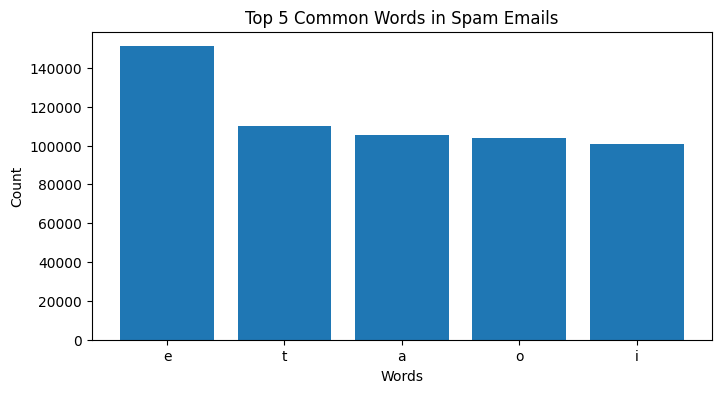

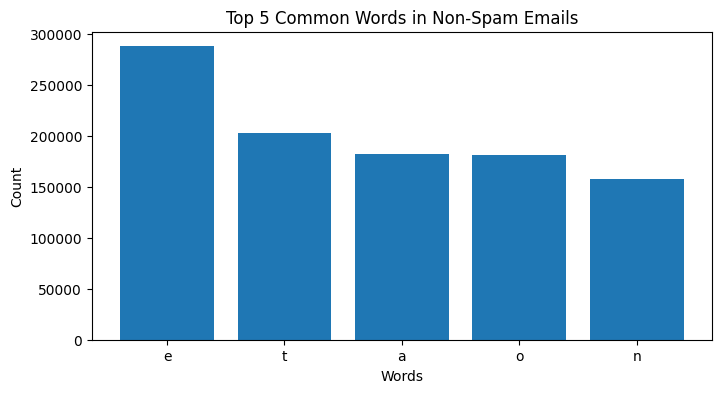

In [ ]:
# Plot histogram to visualize the top 5 common words in spam mail and non-spam mails seperately.

spam_word_counts = spam_emails.iloc[:, 1:-1].sum()
top_spam_words = spam_word_counts.nlargest(5)

non_spam_word_counts = non_spam_emails.iloc[:, 1:-1].sum()
top_non_spam_words = non_spam_word_counts.nlargest(5)


# Prepare data for plotting
spam_words, spam_counts = top_spam_words.index, top_spam_words.values
non_spam_words, non_spam_counts = top_non_spam_words.index, top_non_spam_words.values

# Plot histogram for spam emails
plt.figure(figsize=(8, 4))
plt.bar(spam_words, spam_counts)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 5 Common Words in Spam Emails')
plt.show()

# Plot histogram for non-spam emails
plt.figure(figsize=(8, 4))
plt.bar(non_spam_words, non_spam_counts)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 5 Common Words in Non-Spam Emails')
plt.show()


## Figuring out some comparatively more important features

In [ ]:
# There are 3K rows given in this dataset, can you think of some method to reduce the number of columns in the dataset?
# Try taking only top 1.5K that will comprise of some of the most "deciding factors"


# Calculate the sum of word counts for each column
word_counts = df.iloc[:, 1:-1].sum()

# Sort the columns based on their total frequency in descending order
sorted_words = word_counts.sort_values(ascending=False)

# Select the top 1.5K columns with the highest total frequency
top_words = sorted_words[:1500]

# Create a new dataset with the selected columns
reduced_dataset = df[['Email No.'] + top_words.index.tolist() + ['Prediction']]

reduced_dataset.shape

(5172, 1502)

In [ ]:
reduced_dataset.head()

,Email No.,e,t,a,o,n,i,r,s,l,...,enserch,nothing,become,bellamy,facility,pick,apache,cernosek,features,Prediction
0,Email 1,4,4,2,0,0,2,4,3,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,141,91,102,131,70,61,122,95,35,...,0,0,0,0,0,0,0,0,0,0
2,Email 3,3,3,8,5,8,8,0,2,4,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,79,49,51,48,23,16,46,36,27,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,71,63,57,58,42,30,41,19,34,...,0,0,0,0,0,0,0,0,0,0


## Train - Test Split

In [ ]:
# Create trianing and testing data
df2=df.drop(columns='Email No.')
x = df2.iloc[:, :3000].values
y = df2.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

## Making Predictions using Multinomial NB Classifier

In [ ]:
# Feed the train data into multinomial naive bias classifier

mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred1 = mnb.predict(x_test)
print("Accuracy Score for Naive Bayes : ", accuracy_score(y_pred1, y_test))
print("Precision Score for Naive Bayes : ", precision_score(y_test, y_pred1))

Accuracy Score for Naive Bayes :  0.9420289855072463
Precision Score for Naive Bayes :  0.869942196531792


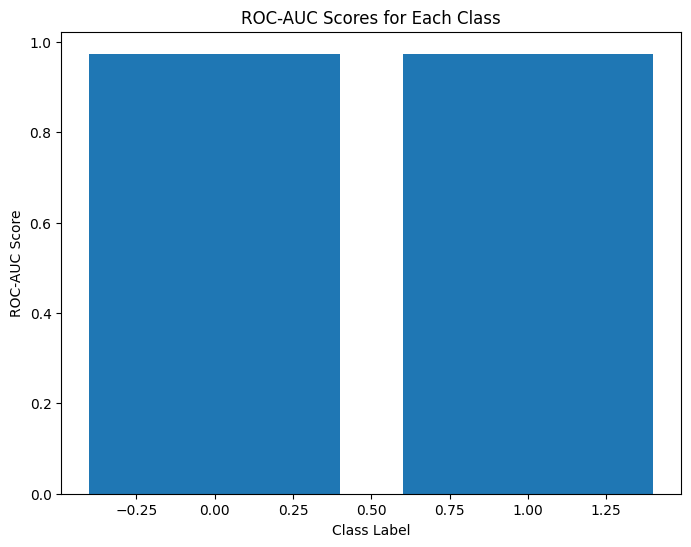

In [ ]:
# Check the model's accuracy of test data and plot the ROC-AUC curve

# Calculate ROC-AUC score for each class
roc_auc_scores = []
for class_label in np.unique(y_test):
    y_true_class = (y_test == class_label).astype(int)
    y_pred_class = classifier.predict_proba(x_test)[:, class_label]
    roc_auc = roc_auc_score(y_true_class, y_pred_class)
    roc_auc_scores.append(roc_auc)

# Plot the ROC-AUC scores for each class
plt.figure(figsize=(8, 6))
plt.bar(np.unique(y_test), roc_auc_scores)
plt.xlabel('Class Label')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Scores for Each Class')
plt.show()


## Plot the confusion Matrix

In [ ]:
# Print Confusion Matrix using any 5 words of your choice with the column 'spam'

selected_columns = ['the', 'to', 'and', 'for', 'of', 'Prediction']

# Create a subset of the data with the selected columns
subset_data = df2[selected_columns]

# Split the subset data into features (X) and target variable (y)
X = subset_data[selected_words]
y = subset_data['Prediction']

# Make predictions on the test data
y_pred = classifier.predict(x_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[674  45]
 [ 15 301]]


## Trying out with SVMs

Accuracy: 0.7990338164251207
Precision score: 0.8698630136986302


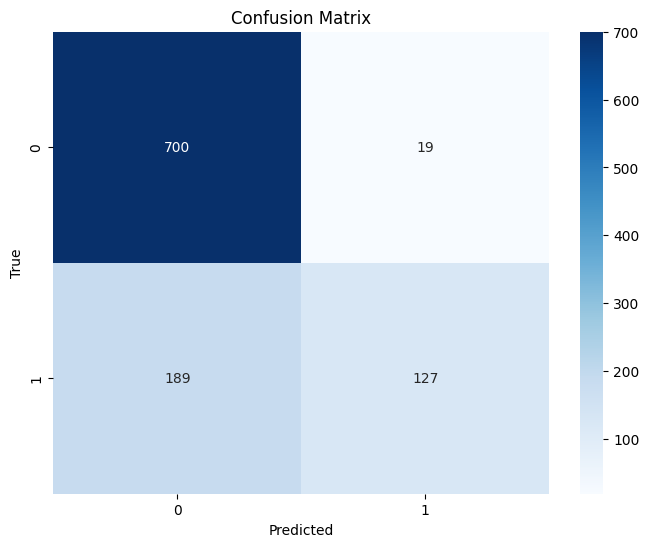

In [ ]:
# Try using Support Vector Classifier (SVC) from scikit-learn
# Apply similar processes as above through SVC i.e., Make prediction, check accuacy and plot confusion matrix

svc = SVC()
svc.fit(x_train, y_train)
y_pred2 = svc.predict(x_test)

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy)

y_pred_SVM = svc.predict(x_test)
print("Precision score:",  precision_score(y_test, y_pred_SVM))

cm = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Comparing the models

{'SVM': {'accuracy': 0.7990338164251207, 'precision': 0.8698630136986302}, 'MN Naive Bayes': {'accuracy': 0.9420289855072463, 'precision': 0.869942196531792}}


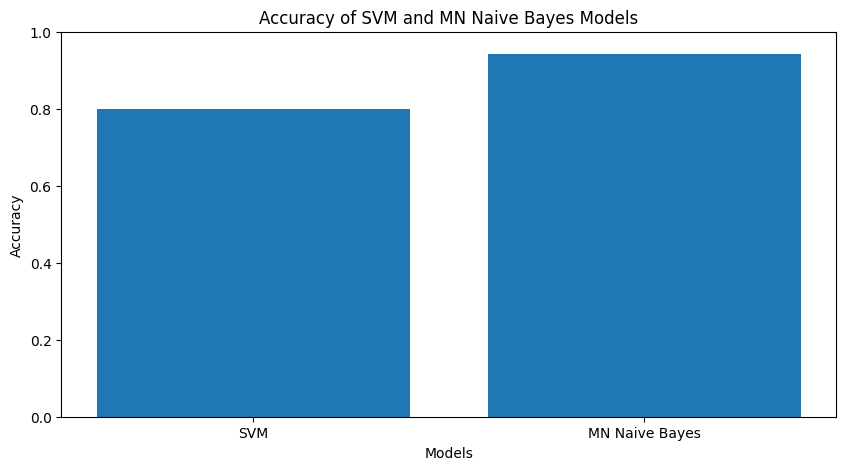

In [ ]:
# Which model performed better?
# Can you suggest some reason for better performance of one model over the other?
results = {}
results["SVM"] = {"accuracy": accuracy, "precision": precision_score(y_test, y_pred_SVM)}
results["MN Naive Bayes"] = {"accuracy": accuracy_score(y_pred1, y_test), "precision": precision_score(y_test, y_pred1)}
print(results)

plt.figure(figsize=(10,5))
plt.bar(results.keys(), [result["accuracy"] for result in results.values()])
plt.title("Accuracy of SVM and MN Naive Bayes Models")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

From above bar graph it is clear that Naive Bayes model has better accuracy than SVM model

## Bonus Question

In [ ]:
# Given a string. Try to create the dataset having each word of dataset as column and row values as the frequency of that word.
# For example
# s = "I am a Python developer and currently working on a project to classify mails"
# dataframe = {"I" : 1,
#              "am" :1,
#              "a" : 2,
#               ...}

In [ ]:

s = "I am a Python developer and currently working on a project to classify mails"
words = s.split()
word_freq = {}
for word in words:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1
df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

print(df)


         Word  Frequency
0           I          1
1          am          1
2           a          2
3      Python          1
4   developer          1
5         and          1
6   currently          1
7     working          1
8          on          1
9     project          1
10         to          1
11   classify          1
12      mails          1
